In [1]:
import os
import findspark
findspark.init() # findspark sekarang sudah terinstal, jadi ini akan berhasil!

from pyspark.sql import SparkSession

os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

spark = SparkSession.builder \
    .appName("BigDataPractice") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

print("Spark success!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/23 22:16:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark success!


In [2]:
#Setup Spark dan DataFrame 
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, count

spark = SparkSession.builder.appName("Tugas1_Department").getOrCreate()

data = [
    ('Aisyah', 'Sales', 34, 5000),
    ('Tegar', 'Sales', 40, 6000),
    ('Tiffany', 'IT', 28, 7000),
    ('Bagas', 'IT', 35, 6500),
    ('Nayla', 'HR', 30, 4800),
    ('Farzan', 'HR', 45, 5200)
]

columns = ['name', 'department', 'age', 'salary']
df = spark.createDataFrame(data, columns)

df.createOrReplaceTempView("employees")

25/10/23 22:22:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#Query Spark SQL
result = spark.sql("""
SELECT department,
       SUM(salary) AS total_salary,
       COUNT(*) AS total_employees
FROM employees
GROUP BY department
""")

result.show()

+----------+------------+---------------+
|department|total_salary|total_employees|
+----------+------------+---------------+
|     Sales|       11000|              2|
|        IT|       13500|              2|
|        HR|       10000|              2|
+----------+------------+---------------+



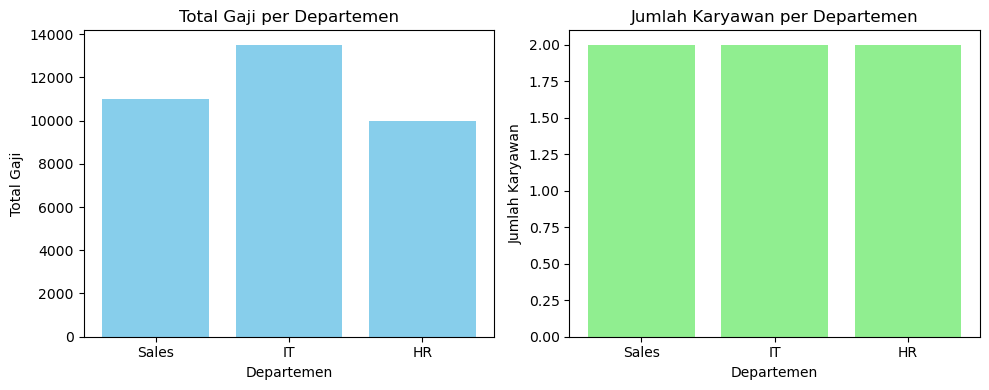

In [4]:
#Visualisasi perbandingan berdampingan
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = result.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(pandas_df['department'], pandas_df['total_salary'], color='skyblue')
axes[0].set_title('Total Gaji per Departemen')
axes[0].set_xlabel('Departemen')
axes[0].set_ylabel('Total Gaji')

axes[1].bar(pandas_df['department'], pandas_df['total_employees'], color='lightgreen')
axes[1].set_title('Jumlah Karyawan per Departemen')
axes[1].set_xlabel('Departemen')
axes[1].set_ylabel('Jumlah Karyawan')

plt.tight_layout()
plt.show()

In [5]:
#Setup Spark dan DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

spark = SparkSession.builder.appName("Tugas2_Karyawan").getOrCreate()

data = [
    ('Aisyah', 34, 5000),
    ('Tegar', 40, 6000),
    ('Tiffany', 28, 7000),
    ('Bagas', 35, 6500),
    ('Nayla', 30, 4800),
    ('Duta', 45, 5200),
    ('Taufiq', 25, 7200),
    ('Ikhsan', 32, 5800)
]

df = spark.createDataFrame(data, ['Nama', 'Umur', 'Gaji'])

df = df.withColumn(
    'Kelompok_Umur',
    when(col('Umur') <= 30, 'Muda')
    .when((col('Umur') > 30) & (col('Umur') <= 40), 'Dewasa')
    .otherwise('Senior')
)

df.createOrReplaceTempView("karyawan")


25/10/23 22:32:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [9]:
#Hitung rata-rata gaji tiap kelompok usia
avg_gaji = spark.sql("""
SELECT Kelompok_Umur, AVG(Gaji) AS Rata2_Gaji
FROM karyawan
GROUP BY Kelompok_Umur
""")
avg_gaji.createOrReplaceTempView("avg_gaji")

In [8]:
#Ambil karyawan yang gajinya di atas rata-rata kelompoknya

above_avg = spark.sql("""
SELECT k.Nama, k.Kelompok_Umur, k.Gaji, a.Rata2_Gaji
FROM karyawan k
JOIN avg_gaji a ON k.Kelompok_Umur = a.Kelompok_Umur
WHERE k.Gaji > a.Rata2_Gaji
ORDER BY k.Kelompok_Umur
""")

above_avg.show()


+-------+-------------+----+-----------------+
|   Nama|Kelompok_Umur|Gaji|       Rata2_Gaji|
+-------+-------------+----+-----------------+
|  Tegar|       Dewasa|6000|           5825.0|
|  Bagas|       Dewasa|6500|           5825.0|
|Tiffany|         Muda|7000|6333.333333333333|
| Taufiq|         Muda|7200|6333.333333333333|
+-------+-------------+----+-----------------+



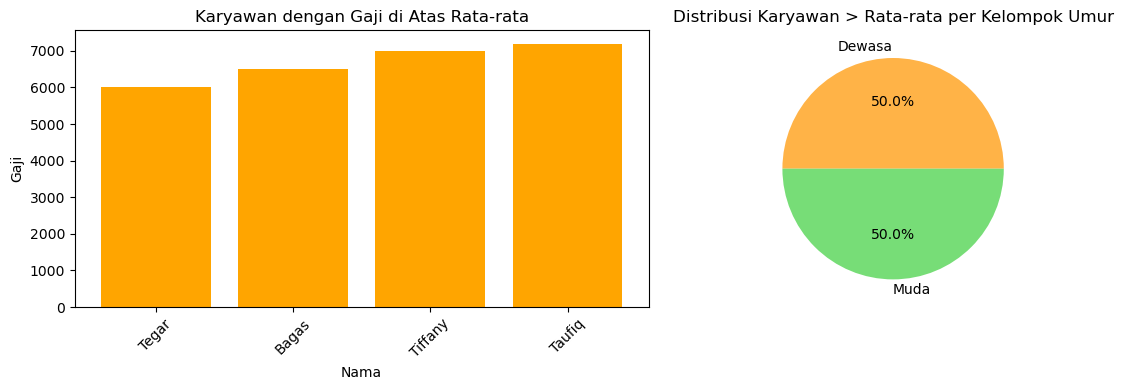

In [10]:
#Bagian Visualisasi 
import pandas as pd
import matplotlib.pyplot as plt

df_plot = above_avg.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(df_plot['Nama'], df_plot['Gaji'], color='orange')
axes[0].set_title('Karyawan dengan Gaji di Atas Rata-rata')
axes[0].set_xlabel('Nama')
axes[0].set_ylabel('Gaji')
axes[0].tick_params(axis='x', rotation=45)

group_count = df_plot['Kelompok_Umur'].value_counts()
axes[1].pie(group_count, labels=group_count.index, autopct='%1.1f%%', colors=['#ffb347','#77dd77','#aec6cf'])
axes[1].set_title('Distribusi Karyawan > Rata-rata per Kelompok Umur')

plt.tight_layout()
plt.show()

In [11]:
#Dataset besar (100+ karyawan)

import random

departemen = ['Sales', 'IT', 'HR', 'Finance', 'Marketing']
data_besar = [
    (f'Karyawan{i}', random.choice(departemen), random.randint(22, 55), random.randint(4000, 12000))
    for i in range(1, 121)
]

df_besar = spark.createDataFrame(data_besar, ['Nama', 'Departemen', 'Umur', 'Gaji'])
df_besar.createOrReplaceTempView("karyawan_besar")


In [12]:
#Tabel bonus untuk JOIN
bonus_data = [(d, random.randint(500, 2000)) for d in departemen]
df_bonus = spark.createDataFrame(bonus_data, ['Departemen', 'Bonus'])
df_bonus.createOrReplaceTempView("bonus")

In [13]:
#Analisis mendalam
analisis = spark.sql("""
SELECT k.Departemen,
       COUNT(*) AS Jumlah_Karyawan,
       AVG(k.Gaji) AS Rata2_Gaji,
       SUM(k.Gaji) AS Total_Gaji,
       b.Bonus AS Bonus_Departemen,
       SUM(k.Gaji) + b.Bonus AS Total_Gaji_Bonus
FROM karyawan_besar k
JOIN bonus b ON k.Departemen = b.Departemen
GROUP BY k.Departemen, b.Bonus
ORDER BY Total_Gaji DESC
""")

analisis.show()

+----------+---------------+-----------------+----------+----------------+----------------+
|Departemen|Jumlah_Karyawan|       Rata2_Gaji|Total_Gaji|Bonus_Departemen|Total_Gaji_Bonus|
+----------+---------------+-----------------+----------+----------------+----------------+
|        IT|             29|8640.586206896553|    250577|            1863|          252440|
|   Finance|             27| 8228.62962962963|    222173|             623|          222796|
| Marketing|             23|8945.217391304348|    205740|             563|          206303|
|        HR|             25|          7820.68|    195517|             855|          196372|
|     Sales|             16|        7138.0625|    114209|             746|          114955|
+----------+---------------+-----------------+----------+----------------+----------------+



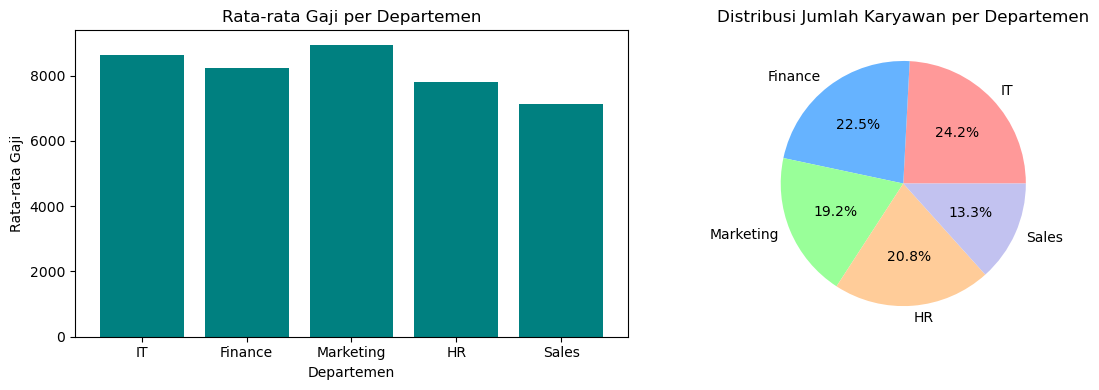

In [14]:
# Bentuk Visualisasi sederhana
df_plot2 = analisis.toPandas()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(df_plot2['Departemen'], df_plot2['Rata2_Gaji'], color='teal')
axes[0].set_title('Rata-rata Gaji per Departemen')
axes[0].set_xlabel('Departemen')
axes[0].set_ylabel('Rata-rata Gaji')

axes[1].pie(df_plot2['Jumlah_Karyawan'], labels=df_plot2['Departemen'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
axes[1].set_title('Distribusi Jumlah Karyawan per Departemen')

plt.tight_layout()
plt.show()